In [1]:
# Metodos y funciones para leer cubo fits

from astropy.io import fits # modulo para leer archivos.fits

cubo = fits.open("Cubo_de_Datos.fits") #abrimos el cubo de datos
data = cubo[0].data # extraemos matriz de datos
header = cubo[0].header #extraemos el header del archivo fits

In [2]:
import numpy as np #este modulo es para trabajar con arreglos en general (vectores, matrices)

# definimos función para extraer ejes del cubo con las unidades correspondientes

def cube_axis(hdr):
    axis = hdr['NAXIS']
    axis_dict = {}
    for i in range(axis):
        min_val_i = float(hdr['CRVAL' + str(i + 1)])
        delt_i = float(hdr['CDELT' + str(i + 1)])
        Naxis_i = int(hdr['NAXIS' + str(i + 1)])
        axis_i = np.linspace(min_val_i, min_val_i + (Naxis_i - 1)*delt_i, Naxis_i)
        axis_dict[hdr['CTYPE' + str(i + 1)]] = axis_i
    return axis_dict

axis_dict = cube_axis(header)

# Extraemos los vectores de los ejes

velocidad = axis_dict['VELO-LSR']
longitud = axis_dict['GLON-FLT']
latitud = axis_dict['GLAT-FLT']

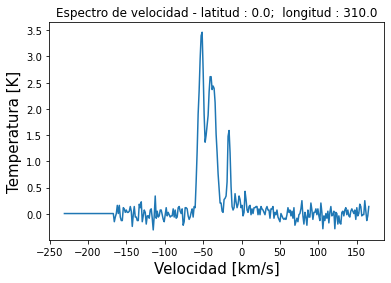

In [3]:
import matplotlib.pyplot as plt

# eje 1: latitud (data[0]) (b)
# eje 2: longitud(data[0][0]) (l)
# eje 3: velocidad (data[0][0][0])

# Funcion para encontrar un indice en un arreglo del valor mas cercano a un valor dado. Solo funciona si el array esta ordenado
def nearest_ind(arr, val):
    ind = 0
    for i in range(len(arr)):
        if arr[i] <= val:
            ind = i
        else:
            return ind
    return ind

# Espectro de velocidad

lat_2 = 0.
lat_2_i = nearest_ind(latitud, lat_2)
lat_2 = latitud[lat_2_i]

lon_2 = 310.
lon_2_i = nearest_ind(longitud, lon_2)
lon_2 = longitud[lon_2_i]

info = 'latitud : ' + str(np.round(lat_2, 4)) + ';  longitud : ' + str(np.round(lon_2, 4))

T_spect = data[lat_2_i][lon_2_i][:]

#ahora graficamos el espectro
plt.plot(velocidad, T_spect)
plt.xlabel('Velocidad [km/s]', fontsize=15)
plt.ylabel('Temperatura [K]', fontsize=15)
plt.title('Espectro de velocidad - ' + info)
plt.show()

# Filtrado de espectro

Al ver un espectro, podemos notar que no todas las mediciones de temperatura corresponden a observaciones. Nos interesa establecer un criterio para poder extraer los datos asociados a observaciones, y separarlas del ruido. Para esto usamos como referencia para la temperatura $\sigma$, que corresponde a la desviacion estandar del "ruido".

\begin{equation}
    \sigma_T = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (T_i - T_{promedio})^2}
\end{equation}

El criterio establecido es el de considerar como observaciones a temperaturas $T \geq 5*\sigma_T$.

In [4]:
from scipy import stats
from astropy.stats import sigma_clip

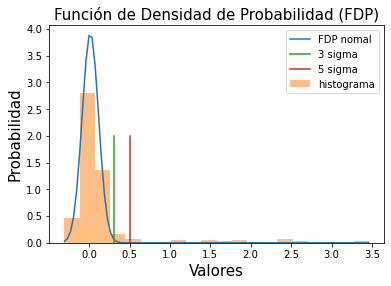

In [5]:
# Primero revisamos la distribucion de probabilidad de temperaturas

r = sigma_clip(T_spect, sigma_lower=3, sigma_upper=3) # extraemos un subconjunto del espectro que contiene ruido principalmente
mean_spect = np.mean(r) # promedio
r = sigma_clip(T_spect, sigma_lower=3, sigma_upper=3) # extraemos un subconjunto del espectro que contiene ruido principalmente
std_spect = np.sqrt(np.mean(r**2)) # desviacion estandar

x_t = np.linspace(min(T_spect), max(T_spect), 100) # vector con rango de T_spect

FDP_normal = stats.norm(mean_spect, std_spect).pdf(x_t) # distribucion de probabilidades normal

plt.plot(x_t, FDP_normal, label='FDP nomal') # graficamos la distribucion de probabilidades
plt.hist(T_spect, density=True, alpha=0.5, bins = 20, label = 'histograma') # graficamos un histograma
plt.plot(np.array([3*std_spect, 3*std_spect]), np.array([0, 2]), label = '3 sigma')
plt.plot(np.array([5*std_spect, 5*std_spect]), np.array([0, 2]), label = '5 sigma')

plt.title('Función de Densidad de Probabilidad (FDP)', fontsize=15)
plt.ylabel('Probabilidad', fontsize=15)
plt.xlabel('Valores', fontsize=15)
plt.legend(loc = 'upper right')
plt.show()

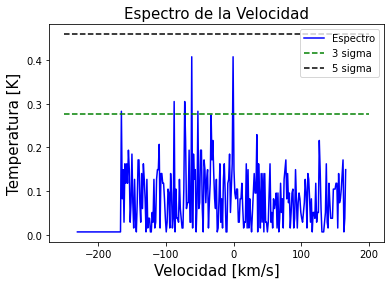

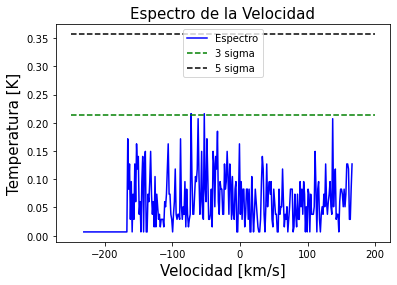

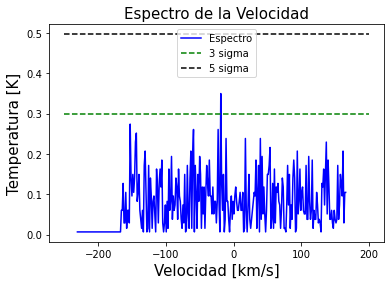

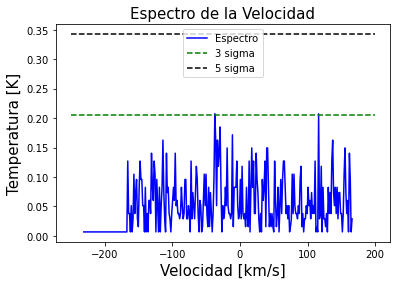

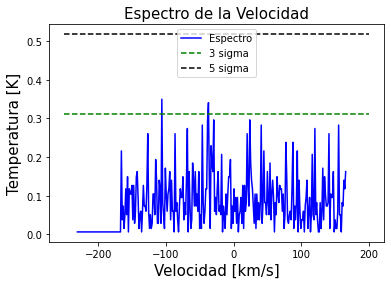

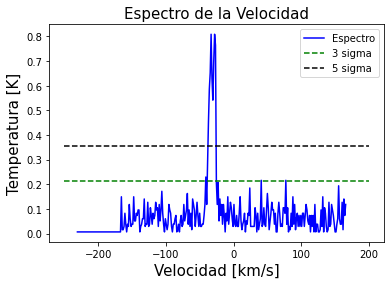

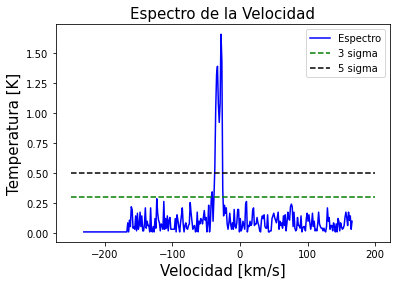

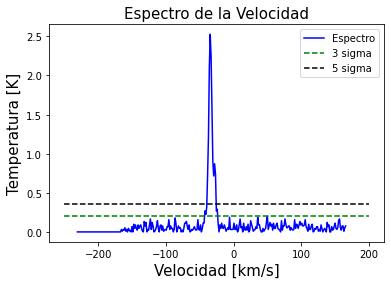

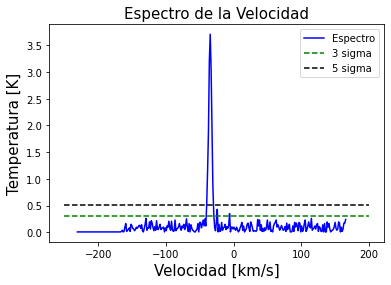

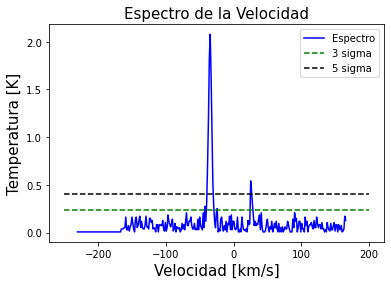

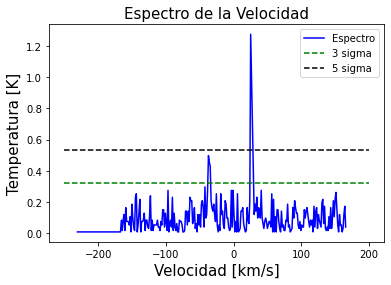

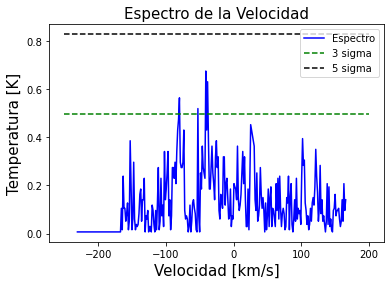

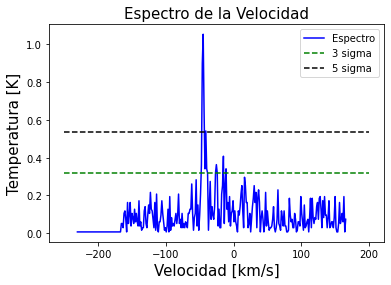

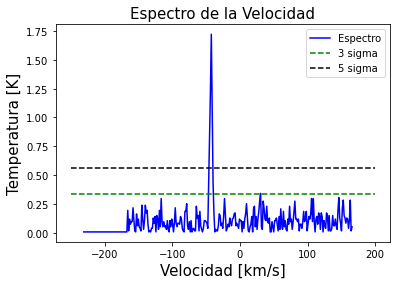

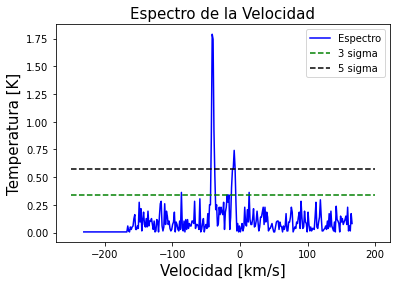

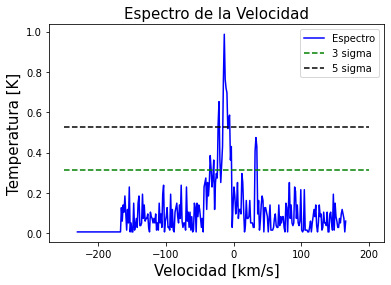

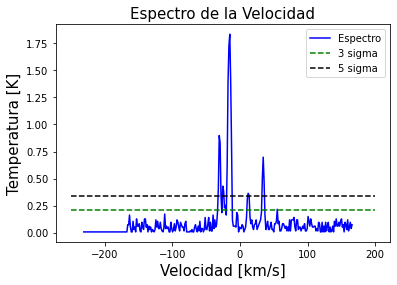

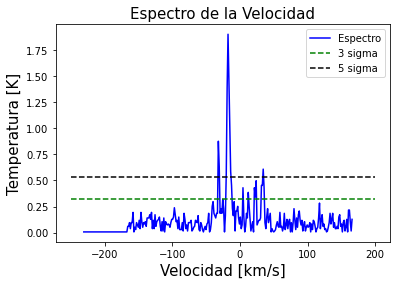

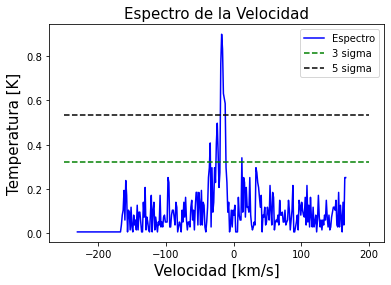

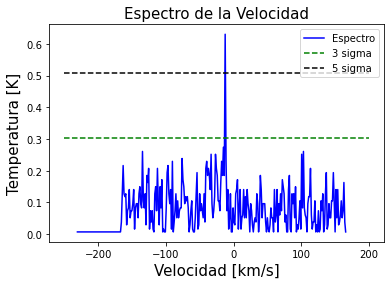

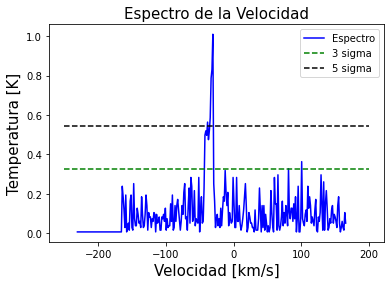

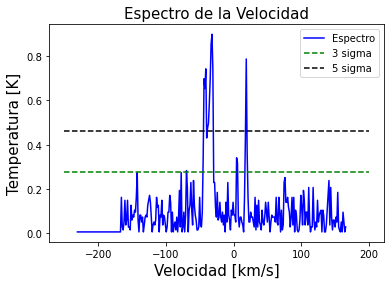

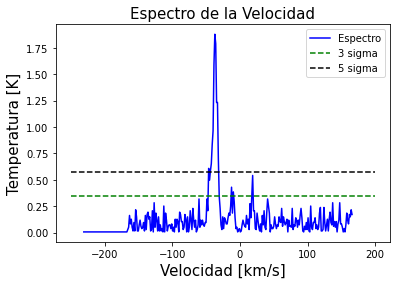

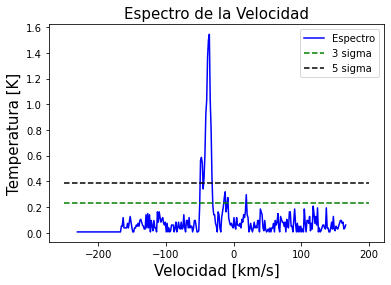

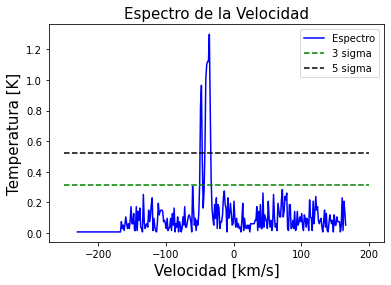

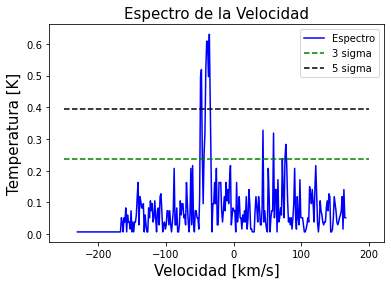

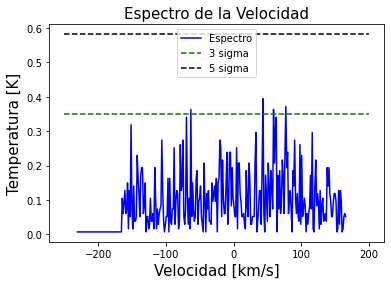

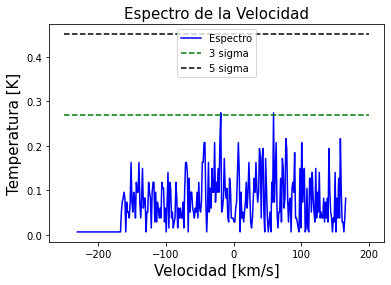

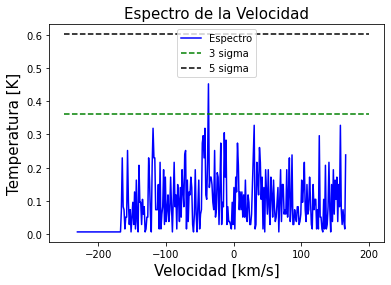

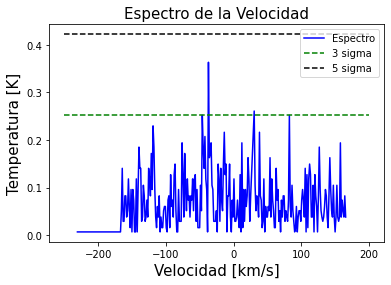

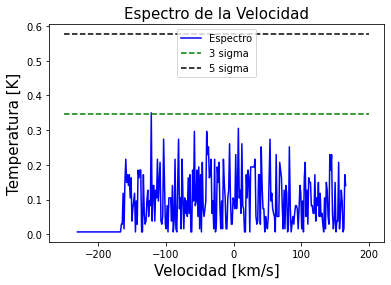

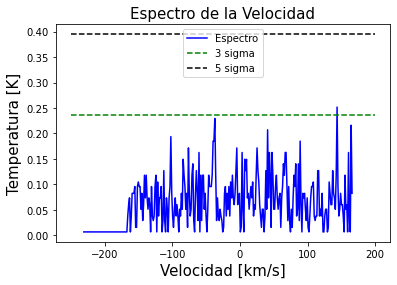

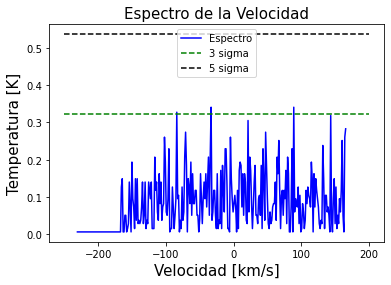

In [6]:
#queremos dibujar una función que nos entregue la velocidad máxima, 
#ie, la velocidad a la cual la temperatura para un espectro es máxima

def dibujo(b,l):# b es la latitud y l es la longitud
    T_spc = data[b][l][:] # espectro de velocidad (temperatura)

    r = sigma_clip(T_spc, sigma_lower=3, sigma_upper=3) # extraemos un subconjunto del espectro que contiene ruido principalmente
    sigma_T = np.sqrt(np.mean(r**2)) # calculamos RMS del subconjunto anterior

    plt.plot(velocidad, abs(T_spc), color='b', label='Espectro')
    plt.plot([-250,200],[3*sigma_T,3*sigma_T], 'g--', label='3 sigma')
    plt.plot([-250,200],[5*sigma_T,5*sigma_T], 'k--', label='5 sigma')
    plt.xlabel('Velocidad [km/s]', fontsize=15)
    plt.ylabel('Temperatura [K]', fontsize=15)
    plt.legend()
    plt.title('Espectro de la Velocidad', fontsize=15)
    plt.show()

#esto nos permite diferenciar una observación de algo que es meramente ruido
for i in np.arange(0,len(latitud)):#dibujo para la longitud l=0
    dibujo(i,0)


# Curva de rotación

### Velocidad tangencial

Nuestro primer objetivo es encontrar la velocidad tangencial asociada a una circunferencia de radio $R = R_\odot \sin(l)$. Para esto, definimos la velocidad tangencial para un par de coordenadas, $V_{max}(l, b)$ como la velocidad del espectro de mayor valor absoluto, para temperaturas de medicion que cumplan la condición $T \geq 5\sigma$. Luego, fijamos $l$ y vamos recorriendo $b$, almacenando las velocidades $V_{max}(l, b)$. La velocidad tangencial que buscamos es el máximo de las velocidades almacenadas anteriormente, y está asociada a la coordenada l.

\begin{equation}
    V_{tan} = V_{max}(l, b^*) \\
    b^* = \arg \max_{b} (V_{max}(l, b))
\end{equation}

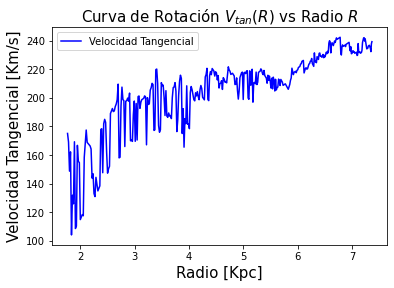

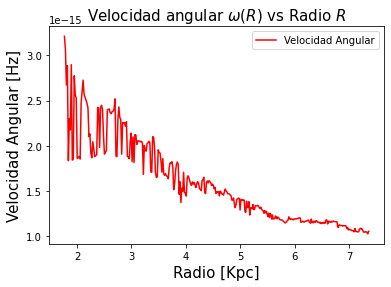

In [7]:
# debemos hacer una función que reciba el cubo de datos y, para una longitud l fija, me entregue un vector 
# que contenga en sí mismo las velocidades máximas para todos los b diferentes correspondientes
# para ese l fijo. Además, solo toma en cuenta los valores que están por debajo de 5 sigma.
from scipy import stats
from astropy.stats import sigma_clip

def v_y_b_maximas(l):# l es la longitud y recorre desde 1 hasta el largo de longitud = len(longitud)
    n = len(latitud)
    vmaxima = [] #velocidad maxima
    for i in np.arange(0,n):# b es la latitud
        T = data[i][l][:] # temperatura
        r = sigma_clip(T, sigma_lower=5, sigma_upper=5) # extraemos un subconjunto del espectro que 
                                                        # contiene ruido principalmente
        sigma_T = np.sqrt(np.mean(r**2)) # calculamos RMS del subconjunto anterior
        velo = []
        for k in np.arange(0,len(T)):#guardamos los índices
            if T[k] >= 5*sigma_T:
                velo = np.append(velo, velocidad[int(k)])            
        largo = len(velo)
        if largo > 0:
            for j in np.arange(0, largo):
                 if (abs(velo[j])) == max(abs(velo)):
                        vmaxima = np.append(vmaxima,abs(velo[j]))
    for i in np.arange(0,n):
        if (abs(vmaxima))[i] == max(abs(vmaxima)):
            return latitud[i], abs(vmaxima[i])
        

# Probemos la función para la longitud l=longitud[0]
velocidades_maximas = np.zeros(len(longitud))
latitudes_maximas = np.zeros(len(longitud))
for i in np.arange(0, len(longitud)):
    [latitudes_maximas[i], velocidades_maximas[i]] = v_y_b_maximas(i)

v = velocidades_maximas
b = latitudes_maximas
l = longitud
R_0 = 8.5 # Kpc
V_0 = 220 # km/s
seno = np.sin(l*(np.pi/180))
abs_seno = abs(seno)
Radio = abs(R_0*seno) # pasamos los angulos a radianes

V_tangencial = abs(v*(seno/abs_seno) + (V_0)*seno)# al menos sé que el problema con 
                                                  # los picks no viene del seno 
    
#Ahora nos interesa calcular la velocidad angular: 
W_angular = V_tangencial/Radio

#Ahora nos dedicamos a graficar la función de curva de rotación:
plt.plot(Radio, V_tangencial, color='b', label='Velocidad Tangencial')
plt.xlabel('Radio [Kpc]',fontsize = 15)
plt.ylabel('Velocidad Tangencial [Km/s]',fontsize = 15)
plt.legend()
plt.title('Curva de Rotación $V_{tan}(R)$ vs Radio $R$', fontsize = 15)
plt.show()

un_parsec = 3.086*(10**16)
    
plt.plot(Radio, W_angular/un_parsec, color='r', label='Velocidad Angular')
plt.xlabel('Radio [Kpc]',fontsize = 15)
plt.ylabel('Velocidad Angular [Hz]',fontsize = 15)
plt.legend()
plt.title('Velocidad angular $\omega (R)$ vs Radio $R$', fontsize = 15)
plt.show()





# Corrugación del plano

Tenemos que dado un ángulo $l$,

\begin{equation}
    R = R_\odot \sin{l} \\
    D = R_\odot \cos{l} \\
    Z = D \tan{b} \sim D b = R_\odot b \cos{l}
\end{equation}

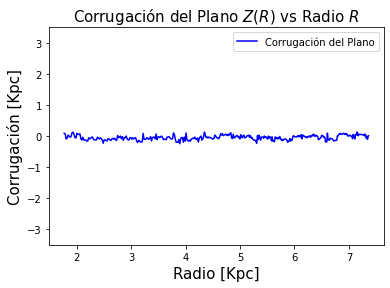

In [8]:
#Ahora queremos modelar la corrugación del plano, que es aproximadamente Z=R_0*b*cos(l)
#por lo cual debemos definir tales variables
R_0 = 8.5 # Kpc
b = latitudes_maximas*(np.pi/180)
l = longitud*(np.pi/180)
Radio = abs(R_0*np.sin(l))
Z = (R_0*b*np.cos(l))

#Ahora nos dedicamos a graficar la función de curva de rotación:
plt.plot(Radio, Z, color='b', label='Corrugación del Plano')
plt.ylim(-3.5,3.5)
plt.xlabel('Radio [Kpc]',fontsize = 15)
plt.ylabel('Corrugación [Kpc]',fontsize = 15)
plt.legend()
plt.title('Corrugación del Plano $Z(R)$ vs Radio $R$',fontsize = 15)
plt.show()

# Modelos de curva de rotación

Ajustamos 5 modelos de la curva de rotación. Lo que hacemos es modelar la masa de la galaxia, y calculamos la velocidad utilizando conservación de energía.

los parámetros son para cada modelo, respectivamente: a) M_0= 3794.49 b) S= 65.98 c) rho= 8.77 d) M_0= 1409.04  y rho= 6.06 e) M_0= 532.3  y S= 57.82


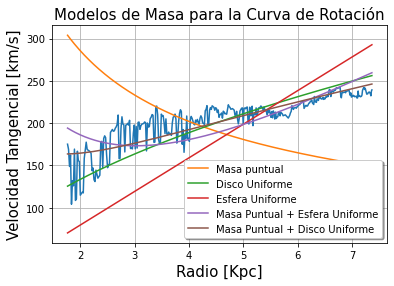

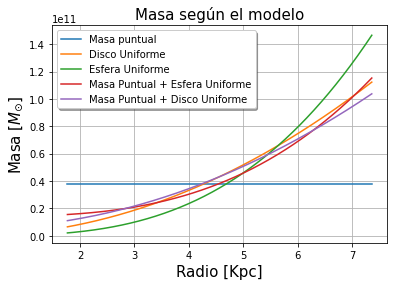

las desviaciones de cada modelo con respecto a la curva de rotación:  65.76 18.58 43.98 21.22 14.64
Las masas totales por modelo son respectivamente, en 100 Mil millones de masas:  2.12 2.72 2.69 2.64 2.68


In [9]:
#La fórmula que tenemos para la conservación de la energía es: (mV**2)/(R) = (GMm)/(r**2), donde m es la masa del sol, 
#M es la masa de la galaxia, V es la velocidad tangencial o de rotación y R es el radio.
#la velocidad tangencial será así; V=np.sqrt((G*Masa)/R)
#Además, queremos usar curve fit para encontrar los parámetros que mejor fiteen a la función f = RV/G - M*,
from numpy import array, exp
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt 

R_0 = 8.5 # Kpc
b = latitudes_maximas*(np.pi/180)
l = longitud*(np.pi/180)
R = abs(R_0*np.sin(l)) #Kpc
V = V_tangencial #km/s
G = 4.3 * (10**(-6)) #Kpc M^{-1}(km/s)^{2}

def f_M_0(R, M):
    return np.sqrt((G*M)/R)
def f_M_disco_unif(R, S):#V y R son los datos
    M = np.pi*(R**2)*S
    return np.sqrt((G*M)/R)
def f_M_Esfera_unif(R,  rho):
    M = (4/3)*np.pi*(R**3)*rho
    return np.sqrt((G*M)/R)
def f_M_punt_y_esf(R,  rho, M_0):
    M = M_0 + (4/3)*np.pi*(R**3)*rho
    return np.sqrt((G*M)/R)
def f_M_punt_y_disc(R,  S, M_0):
    M = M_0 + np.pi*(R**2)*S
    return np.sqrt((G*M)/R)

params1, covs1 = curve_fit(f_M_0, R, V)
params2, covs2 = curve_fit(f_M_disco_unif, R, V)
params3, covs3 = curve_fit(f_M_Esfera_unif, R, V)
params4, covs4 = curve_fit(f_M_punt_y_esf, R, V)
params5, covs5 = curve_fit(f_M_punt_y_disc, R, V)

a1 = params1[0]
a2 = params2[0]
a3 = params3[0]
a4, b4 = params4[0], params4[1]
a5, b5 = params5[0], params5[1]

Vfit1 = f_M_0(R, a1)
Vfit2 = f_M_disco_unif(R, a2)
Vfit3 = f_M_Esfera_unif(R,  a3)
Vfit4 = f_M_punt_y_esf(R,  a4, b4)
Vfit5 = f_M_punt_y_disc(R,  a5, b5)

print("los parámetros son para cada modelo, respectivamente: a) M_0=",
      round(a1/(10**7),2), "b) S=", round(a2/(10**7),2), "c) rho=", round(a3/(10**7),2), 
      "d) M_0=", round(b4/(10**7),2)," y rho=", round(a4/(10**7),2),"e) M_0=",
      round(b5/(10**7),2)," y S=", round(a5/(10**7),2))

plt.plot(R, V)
plt.plot(R, Vfit1, label="Masa puntual")
plt.plot(R, Vfit2, label="Disco Uniforme")
plt.plot(R, Vfit3, label="Esfera Uniforme")
plt.plot(R, Vfit4, label="Masa Puntual + Esfera Uniforme")
plt.plot(R, Vfit5, label="Masa Puntual + Disco Uniforme")

plt.xlabel('Radio [Kpc]',fontsize = 15)
plt.ylabel('Velocidad Tangencial [km/s]',fontsize = 15)
plt.title('Modelos de Masa para la Curva de Rotación',fontsize = 15)
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

def Masa(r,v):
    return ((v**2)*r)/G
#graficamos igualmente la masa de la galaxia en función del radio
plt.plot(R, Masa(R,Vfit1), label="Masa puntual")
plt.plot(R, Masa(R,Vfit2), label="Disco Uniforme")
plt.plot(R, Masa(R,Vfit3), label="Esfera Uniforme")
plt.plot(R, Masa(R,Vfit4), label="Masa Puntual + Esfera Uniforme")
plt.plot(R, Masa(R,Vfit5), label="Masa Puntual + Disco Uniforme")

plt.xlabel('Radio [Kpc]',fontsize = 15)
plt.ylabel('Masa [$M_{\odot}$]',fontsize = 15)
plt.title('Masa según el modelo',fontsize = 15)
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

#igualmente queremos por ejemplo conocer qué curva se parece más a la curva de rotación:

sigma_1 = np.std(Vfit1-V)
sigma_2 = np.std(Vfit2-V)
sigma_3 = np.std(Vfit3-V)
sigma_4 = np.std(Vfit4-V)
sigma_5 = np.std(Vfit5-V)
print("las desviaciones de cada modelo con respecto a la curva de rotación: ", 
      round(sigma_1,2),round(sigma_2,2),round(sigma_3,2),
      round(sigma_4,2),round(sigma_5,2))

#además, queremos conocer la masa total que hay bajo la curva de masa para los 5 modelos:
#falta con conocer la integral de las primeras 3 masas, con parámetros determinados por
#curve_fit:
Rmax = max(R) 
Rmin = min(R)
M_total_puntual = a1*(Rmax-Rmin)#integramos M_0=a1
M_total_Disco = (np.pi/3)*(Rmax**3-Rmin**3)*a2 #integramos pi r**2 s, s=a2
M_total_Esfera = (np.pi/3)*(Rmax**4-Rmin**4)*a3 #integramos 4/3 pi r**3 rho, rho=a3
M_total_p_y_E = b4*(Rmax-Rmin) + (np.pi/3)*(Rmax**4-Rmin**4)*a4
M_total_p_y_D = b5*(Rmax-Rmin) + (np.pi/3)*(Rmax**3-Rmin**3)*a5

N=10**(-11)
print("Las masas totales por modelo son respectivamente, en 100 Mil millones de masas: ", 
      round(M_total_puntual*N,2), round(M_total_Disco*N,2), round(M_total_Esfera*N,2),
      round(M_total_p_y_E*N,2), round(M_total_p_y_D*N,2))

In [11]:
print(latitud, longitud)

[-2.    -1.875 -1.75  -1.625 -1.5   -1.375 -1.25  -1.125 -1.    -0.875
 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.     0.125  0.25   0.375
  0.5    0.625  0.75   0.875  1.     1.125  1.25   1.375  1.5    1.625
  1.75   1.875  2.   ] [300.    300.125 300.25  300.375 300.5   300.625 300.75  300.875 301.
 301.125 301.25  301.375 301.5   301.625 301.75  301.875 302.    302.125
 302.25  302.375 302.5   302.625 302.75  302.875 303.    303.125 303.25
 303.375 303.5   303.625 303.75  303.875 304.    304.125 304.25  304.375
 304.5   304.625 304.75  304.875 305.    305.125 305.25  305.375 305.5
 305.625 305.75  305.875 306.    306.125 306.25  306.375 306.5   306.625
 306.75  306.875 307.    307.125 307.25  307.375 307.5   307.625 307.75
 307.875 308.    308.125 308.25  308.375 308.5   308.625 308.75  308.875
 309.    309.125 309.25  309.375 309.5   309.625 309.75  309.875 310.
 310.125 310.25  310.375 310.5   310.625 310.75  310.875 311.    311.125
 311.25  311.375 311.5   311.625 311.75  311